In [352]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import gc
import time
from sklearn.metrics import matthews_corrcoef
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from torch import nn
import random
from tqdm.auto import tqdm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam, lr_scheduler

In [3]:
DATASET_DIR = "nfl-player-contact-detection"

# player tracking
train_player_tracking_df = pd.read_csv(os.path.join(DATASET_DIR, "train_player_tracking.csv"), 
                                      parse_dates=["datetime"])

# helmet detection
train_helmet_det_df = pd.read_csv(os.path.join(DATASET_DIR, "train_baseline_helmets.csv"))

# video metadata
train_video_metadata_df = pd.read_csv(os.path.join(DATASET_DIR, "train_video_metadata.csv"), 
                                      parse_dates=["start_time", "end_time", "snap_time"])

# train labels
train_labels_df =  pd.read_csv(os.path.join(DATASET_DIR, "train_labels.csv"), 
                               parse_dates=["datetime"])

# load the submission dataframe
input_df = pd.read_csv(os.path.join(DATASET_DIR, "sample_submission.csv"))

## Extract frame images from videos

In [15]:
FRAMES_DIR = "frames"

!mkdir -p {FRAMES_DIR}

for video in tqdm(train_helmet_det_df['video'].unique()):
    if 'Endzone2' not in video:
        !C:/ffmpeg/bin/ffmpeg -i nfl-player-contact-detection/train/{video} -q:v 2 -f image2 frames/{video}_%04d.jpg -hide_banner -loglevel error

A subdirectory or file -p already exists.
Error occurred while processing: -p.


  0%|          | 0/481 [00:00<?, ?it/s]

In [16]:
# create a dataframe with the max frame per video
video_max_frames = pd.DataFrame()
frame_names_split = np.array([video.split('_') for video in os.listdir(FRAMES_DIR)])
video_max_frames['video'] = [f'{x[0]}_{x[1]}_{x[2]}' for x in frame_names_split]
video_max_frames['frame'] = [int(x[-1].split('.')[0]) for x in frame_names_split]
video_max_frames = video_max_frames.groupby('video')[['frame']].max()

# convert to dictionary (simpler to access)
video_max_frames = video_max_frames.to_dict()['frame']
video_max_frames

{'58168_003392_Endzone.mp4': 711,
 '58168_003392_Sideline.mp4': 711,
 '58172_003247_Endzone.mp4': 1084,
 '58172_003247_Sideline.mp4': 1084,
 '58173_003606_Endzone.mp4': 1136,
 '58173_003606_Sideline.mp4': 1136,
 '58174_001792_Endzone.mp4': 774,
 '58174_001792_Sideline.mp4': 774,
 '58176_002844_Endzone.mp4': 645,
 '58176_002844_Sideline.mp4': 645,
 '58177_004239_Endzone.mp4': 729,
 '58177_004239_Sideline.mp4': 729,
 '58180_000986_Endzone.mp4': 1043,
 '58180_000986_Sideline.mp4': 1043,
 '58180_004644_Endzone.mp4': 591,
 '58180_004644_Sideline.mp4': 591,
 '58187_001341_Endzone.mp4': 727,
 '58187_001341_Sideline.mp4': 727,
 '58187_001383_Endzone.mp4': 893,
 '58187_001383_Sideline.mp4': 893,
 '58187_001691_Endzone.mp4': 911,
 '58187_001691_Sideline.mp4': 911,
 '58187_002329_Endzone.mp4': 679,
 '58187_002329_Sideline.mp4': 679,
 '58187_002815_Endzone.mp4': 820,
 '58187_002815_Sideline.mp4': 820,
 '58187_003092_Endzone.mp4': 803,
 '58187_003092_Sideline.mp4': 803,
 '58188_001358_Endzone.mp4':

In [17]:
video_max_frames['58168_003392_Sideline.mp4']

711

## Utils

In [18]:
def array_to_image(image_array):
    """returns a PIL image converted from the given image array"""
    if len(image_array) == 0:
        return []
    return Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR))

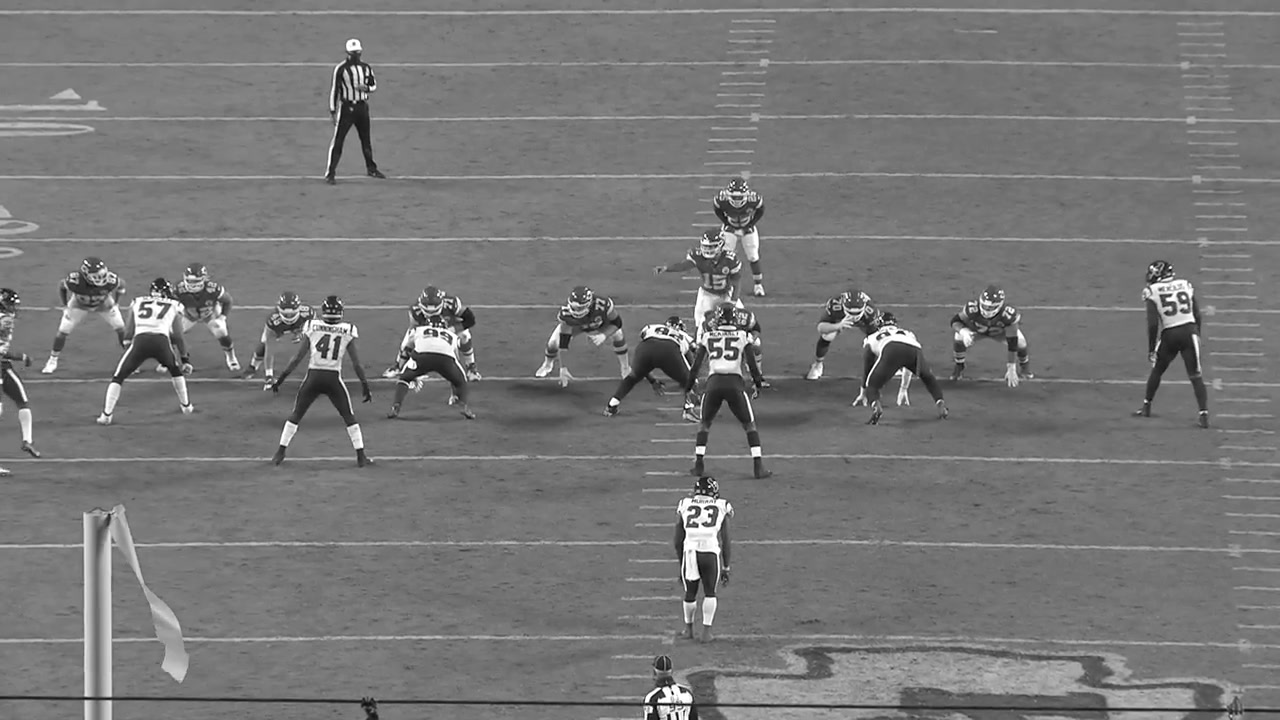

In [19]:
array_to_image(cv2.imread(os.path.join(FRAMES_DIR, '58168_003392_Endzone.mp4_0030.jpg'), 0))

## Data Preprocessing

In [20]:
# create the column frames in the tracking dataframe
train_player_tracking_df['frame'] = ((train_player_tracking_df['step']/10*59.94)+5*59.94).astype('int')+1
train_player_tracking_df

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa,frame
0,58580_001136,58580,1136,44830,2021-10-10 21:08:20.900000+00:00,-108,away,CB,22,61.59,42.60,1.11,0.11,320.33,263.93,0.71,-0.64,-346
1,58580_001136,58580,1136,47800,2021-10-10 21:08:20.900000+00:00,-108,away,DE,97,59.48,26.81,0.23,0.01,346.84,247.16,1.29,0.90,-346
2,58580_001136,58580,1136,52444,2021-10-10 21:08:20.900000+00:00,-108,away,FS,29,72.19,31.46,0.61,0.06,11.77,247.69,0.63,-0.33,-346
3,58580_001136,58580,1136,46206,2021-10-10 21:08:20.900000+00:00,-108,home,TE,86,57.37,22.12,0.37,0.04,127.85,63.63,0.69,0.62,-346
4,58580_001136,58580,1136,52663,2021-10-10 21:08:20.900000+00:00,-108,away,ILB,48,63.25,27.50,0.51,0.05,183.62,253.71,0.31,0.31,-346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353048,58575_003081,58575,3081,48476,2021-10-10 19:22:06.800000+00:00,140,away,CB,40,72.28,51.80,1.59,0.17,345.36,342.68,0.49,-0.41,1139
1353049,58575_003081,58575,3081,44887,2021-10-10 19:22:06.800000+00:00,140,away,ILB,45,74.76,54.50,0.98,0.10,342.39,354.46,0.63,-0.24,1139
1353050,58575_003081,58575,3081,44174,2021-10-10 19:22:06.800000+00:00,140,away,ILB,49,74.54,55.75,1.12,0.11,352.79,349.20,0.63,0.46,1139
1353051,58575_003081,58575,3081,45217,2021-10-10 19:22:06.800000+00:00,140,away,TE,82,80.44,48.77,1.93,0.20,340.78,346.51,0.53,-0.51,1139


In [27]:
# create a dictionary with helmet detections divided by video
video_helmets_dict = {}
for video in tqdm(train_helmet_det_df["video"].unique()):
    video_helmets_dict[video] = train_helmet_det_df[train_helmet_det_df['video'] == video] \
                                .reset_index(drop=True)
    
del train_helmet_det_df

  0%|          | 0/481 [00:00<?, ?it/s]

In [28]:
len(video_helmets_dict)

481

In [29]:
video_helmets_dict['58168_003392_Endzone.mp4']

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33
...,...,...,...,...,...,...,...,...,...,...,...,...
7069,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,709,41257,V21,1034,37,156,46
7070,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,709,43395,V23,818,39,414,49
7071,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,709,37211,H42,579,46,205,41
7072,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,709,46445,H48,694,40,150,46


### Create the contact dataframe

In [35]:
def extract_contact_id_info(input_df):
    # game_key, play_id, player_1_id, player_2_id, step
    contact_df = pd.DataFrame()
    split = input_df['contact_id'].str.split("_")
    contact_df['contact_id'] = input_df['contact_id']
    contact_df['game_play'] = split.str[0]+'_'+split.str[1]
    contact_df['step'] = split.str[2].astype("int")
    contact_df['nfl_player_id_1'] = split.str[3]
    contact_df['nfl_player_id_2'] = split.str[4]
    # replace ground 'G' players id with '-1'
    contact_df.loc[contact_df["nfl_player_id_2"] == 'G', 'nfl_player_id_2'] = '-1'
    contact_df['nfl_player_id_1'] = contact_df['nfl_player_id_1'].astype('int')
    contact_df['nfl_player_id_2'] = contact_df['nfl_player_id_2'].astype('int')
    
    return contact_df

In [36]:
def add_contact_tracking_info(contact_df, tracking_df):
    """
    Joins a contact dataframe with player tracking dataframe on both players
    """
    player_specific_columns=["team", "position", "jersey_number",
                              "x_position", "y_position", "speed", 
                              "distance", "direction", "orientation",
                              "acceleration", "sa"]
    # join on player 1
    contact_df = contact_df.merge(tracking_df, 
                                 left_on=['game_play', 'nfl_player_id_1', 'step'], 
                                 right_on=['game_play', 'nfl_player_id', 'step'], 
                                 how='left').drop_duplicates()
    # remove the repeated column
    contact_df.drop(["nfl_player_id"], axis=1, inplace=True)
    # rename player 1 specific tracking data
    contact_df.rename(columns=lambda x: x+'_1' if x in player_specific_columns else x, inplace=True)

    # join on player 2
    # avoid repeating the "game_key", "play_id", 'datetime' columns
    contact_df = contact_df.merge(tracking_df.drop(['game_key', 'play_id', 'datetime'], axis=1), 
                                 left_on=['game_play', 'nfl_player_id_2', 'step'], 
                                 right_on=['game_play', 'nfl_player_id', 'step'], 
                                 how='left').drop_duplicates()
    # remove the repeated column
    contact_df.drop("nfl_player_id", axis=1, inplace=True)
    # rename player 2 specific tracking data
    contact_df.rename(columns=lambda x: x+'_2' if x in player_specific_columns else x, inplace=True)
    contact_df.replace(np.nan, 0, inplace=True)
    
    return contact_df

In [37]:
def compute_distance(contact_df):
    # compute the distance between 2 players
    contact_df["p2p_distance"] = np.sqrt(
        np.square(contact_df["x_position_1"] - contact_df["x_position_2"])
        + np.square(contact_df["y_position_1"] - contact_df["y_position_2"])
    )
    # set the distance between a player and the ground to 999
    contact_df.loc[contact_df["nfl_player_id_2"]==-1, 'p2p_distance'] = 999
    contact_df['p2p_distance'] = contact_df['p2p_distance'].fillna(999)
    return contact_df

In [38]:
def preprocess_input(input_df, tracking_df):
    """Returns the preprocessed dataframe with all the expanded contact_id info, tracking data, distance
    and ground truth"""
    # tracking df contains all data from the test tracking df
    contact_df = extract_contact_id_info(input_df)
    # add tracking info to the contact df
    contact_df = add_contact_tracking_info(contact_df, tracking_df)
    contact_df = contact_df.fillna(0)
    # compute player distance
    contact_df = compute_distance(contact_df)
    # add the frame number
    contact_df['frame'] = ((contact_df['step']/10*59.94)+5*59.94).astype('int')+1

    return contact_df

In [41]:
train_contact_df = preprocess_input(train_labels_df, train_player_tracking_df)
# add contact label
train_contact_df['contact_true'] = train_labels_df['contact']

MAX_DISTANCE_THRS = 2 # found with training set
# filter the contacts with p2p distance < MAX_DISTANCE_THRS and contacts with the floor
train_contact_df = train_contact_df[(train_contact_df['p2p_distance'] < MAX_DISTANCE_THRS) | 
                                    (train_contact_df['nfl_player_id_2'] == -1)]

print(train_contact_df.columns)
train_contact_df

Index(['contact_id', 'game_play', 'step', 'nfl_player_id_1', 'nfl_player_id_2',
       'game_key', 'play_id', 'datetime', 'team_1', 'position_1',
       'jersey_number_1', 'x_position_1', 'y_position_1', 'speed_1',
       'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1',
       'frame_x', 'team_2', 'position_2', 'jersey_number_2', 'x_position_2',
       'y_position_2', 'speed_2', 'distance_2', 'direction_2', 'orientation_2',
       'acceleration_2', 'sa_2', 'frame_y', 'p2p_distance', 'frame',
       'contact_true'],
      dtype='object')


,contact_id,game_play,step,nfl_player_id_1,nfl_player_id_2,game_key,play_id,datetime,team_1,position_1,...,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,frame_y,p2p_distance,frame,contact_true
10,58168_003392_0_38590_44822,58168_003392,0,38590,44822,58168,3392,2020-09-11 03:01:48.100000+00:00,home,G,...,1.41,0.13,241.73,128.82,2.45,2.43,300.0,1.833712,300,0
11,58168_003392_0_38590_39947,58168_003392,0,38590,39947,58168,3392,2020-09-11 03:01:48.100000+00:00,home,G,...,0.99,0.09,163.38,90.69,1.68,1.64,300.0,1.466595,300,0
13,58168_003392_0_38590_42565,58168_003392,0,38590,42565,58168,3392,2020-09-11 03:01:48.100000+00:00,home,G,...,0.86,0.08,183.83,94.13,1.55,1.54,300.0,1.897077,300,0
50,58168_003392_0_41944_42565,58168_003392,0,41944,42565,58168,3392,2020-09-11 03:01:48.100000+00:00,away,DT,...,0.86,0.08,183.83,94.13,1.55,1.54,300.0,1.378006,300,0
119,58168_003392_0_37211_46445,58168_003392,0,37211,46445,58168,3392,2020-09-11 03:01:48.100000+00:00,home,FB,...,1.10,0.10,148.93,92.39,2.03,2.03,300.0,1.258014,300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721613,58582_003121_91_48220_G,58582_003121,91,48220,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,home,G,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,999.000000,846,0
4721614,58582_003121_91_47906_G,58582_003121,91,47906,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,home,G,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,999.000000,846,0
4721615,58582_003121_91_38557_G,58582_003121,91,38557,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,home,G,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,999.000000,846,0
4721616,58582_003121_91_47872_G,58582_003121,91,47872,-1,58582,3121,2021-10-12 02:42:29.100000+00:00,away,MLB,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,999.000000,846,0


## Crop Images

In [42]:
def fixed_crop(image_array, crop_size, center_x, center_y):
    """
    Returns a crop of the given image with a fixed size with its center at (center_x, center_y) 
    """
    img_height, img_width = image_array.shape
    # create a black image to put the crop in or return if no crop can be created
    final_crop = np.zeros((crop_size, crop_size), dtype=np.uint8)
    # compute the coordinates of the crop by adding or substracting the crop_size/2 to the center points
    y_min = max(0, int(center_y - crop_size/2))
    y_max = min(img_height, int(center_y + crop_size/2))
    x_min = max(0, int(center_x - crop_size/2))
    x_max = min(img_width, int(center_x + crop_size/2))
    # crop the image using the coordinates
    crop = image_array[y_min:y_max, x_min:x_max]
    # fill the black image with the crop
    final_crop[:crop.shape[0], :crop.shape[1]] = crop
    
    return final_crop

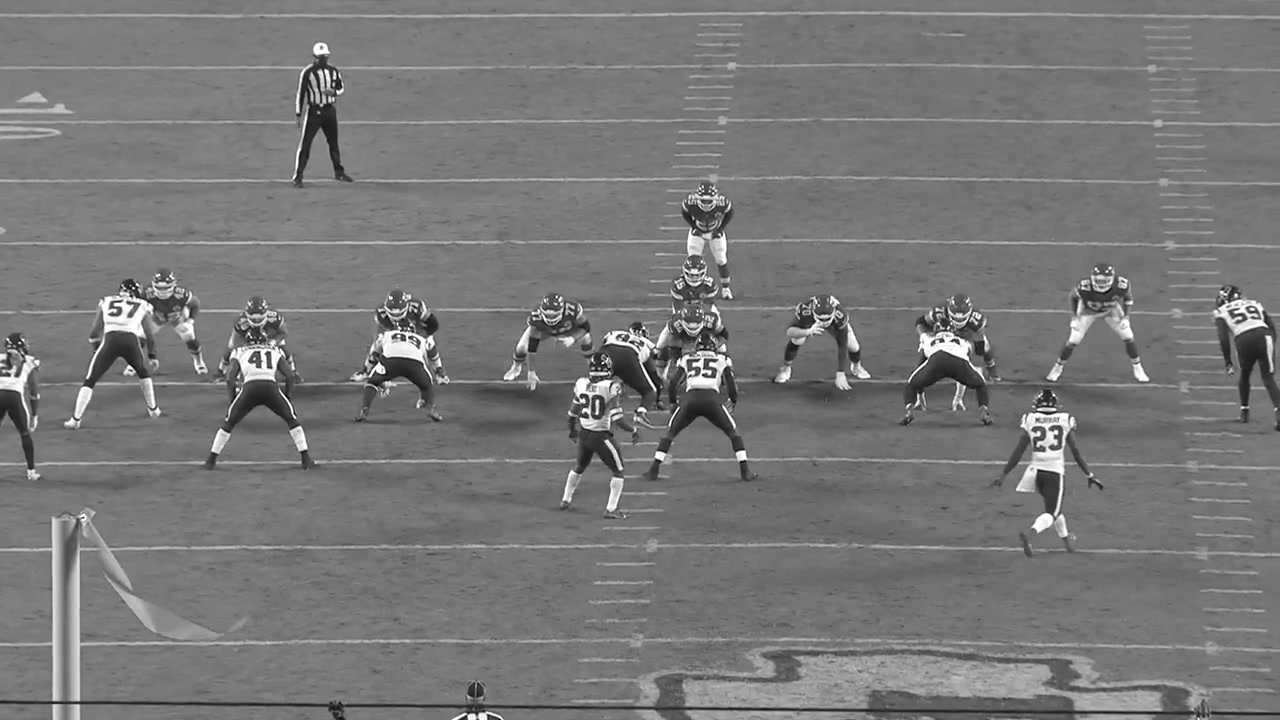

In [43]:
img_array = cv2.imread(os.path.join(FRAMES_DIR, '58168_003392_Endzone.mp4_0290.jpg'), 0)
array_to_image(img_array)

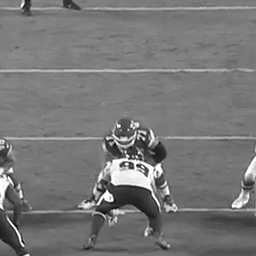

In [44]:
array_to_image(fixed_crop(img_array, crop_size = 256, 
                          center_x = 400, center_y = 300))

In [45]:
def get_contact_image(game_play, frame, player_id_1, player_id_2, 
                      frames_dir=FRAMES_DIR, crop_size=256, frame_window=24):
    """
    Returns the concatenated cropped black and white images of the two players in the two view options.
    From the frame given, the function will also return the cropped images from the previous frames and next frames
    set by the frame_window parameter at a step of 4 frames.
    The final shape of the returned concatenated image will be: (2*((2*frame_window)/4)+1), img_height, img_width)
    """
    # initialize empty cropped images list
    crops = []
    for view in ['Endzone', 'Sideline']:
        video_name = f"{game_play}_{view}.mp4"
        helmets_df = video_helmets_dict[video_name]
        # filter rows with frames inside frame window
        helmets_df = helmets_df[helmets_df['frame'].between(frame - frame_window, frame + frame_window)]
        # filter rows with player ids from the 2 contact players
        helmets_df = helmets_df[helmets_df['nfl_player_id'].isin([player_id_1, player_id_2])]
        found_frames = helmets_df['frame'].unique()
        # group by frame and compute the mean between the boxes coordinates of both players in that frame
        # this returns the centered box between the 2 boxes by adding the width to left and height to top
        helmets_df = helmets_df.groupby('frame')[['left', 'width', 'top', 'height']].mean()
        # initialize empty centered boxes array
        centered_boxes = []
        for selected_frame in range(frame-frame_window, frame+frame_window+1, 1):
            # if there were helmet detections in that frame
            if selected_frame in found_frames:
                xmin, box_width, y_min, box_height = helmets_df.loc[selected_frame]
                centered_boxes.append([xmin, box_width, y_min, box_height])
            # if there were no helmets detected, fill box with nan
            else:
                centered_boxes.append([np.nan, np.nan, np.nan, np.nan])
                
        # interpolate box values along the frames if there are some filled with nan
        centered_boxes = pd.DataFrame(centered_boxes).interpolate(limit_direction='both').values
        # create a flag that indicates that boxes were found and not all are nan
        boxes_found = centered_boxes.sum() > 0

        # create 1 crop image every 4 frames inside the frame_window
        for i, selected_frame in enumerate(range(frame-frame_window, frame+frame_window+1, 4)):
            # create a black image to put the crop in or return if no crop can be created
            new_crop = np.zeros((crop_size, crop_size), dtype=np.uint8)
            # if helmet boxes were found and the frame is not over the video max frame
            if boxes_found and selected_frame <= video_max_frames[video_name]:
                img_array = cv2.imread(os.path.join(frames_dir, f'{video_name}_{selected_frame:04d}.jpg'), 0)
                # get the fixed crop at the center of that frame centered box
                box = centered_boxes[i*4]
                center_x = int(box[0] + (box[1] / 2))
                center_y = int(box[2] + (box[3] / 2))
                new_crop = fixed_crop(img_array, crop_size = crop_size, 
                                      center_x = center_x, center_y = center_y)
            crops.append(new_crop)
            
    return np.array(crops)

(26, 256, 256)


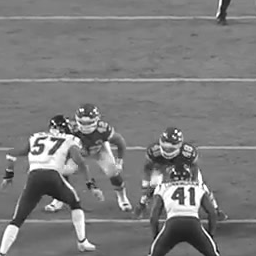

In [148]:
crops = get_contact_image('58168_003392', 300, 46445, 37211)
print(crops.shape)
array_to_image(crops[6])

## Utils to visualize the contact image

In [47]:
def get_helmet_detections(helmet_detection_df, frame_number, view):
    
    detections = helmet_detection_df[(helmet_detection_df['frame'] == frame_number) & 
                            (helmet_detection_df['view'] == view)
                            ][['left', 'width', 'top', 'height', 'nfl_player_id']].values
    
    boxes, labels = detections[:, :-1], detections[:, -1]
    # convert boxes to standard format of:
    # [xmin, ymin, xmax, ymax]
    boxes_st = boxes.copy()
    boxes_st[:, 1] = boxes[:, 2] # ymin
    boxes_st[:, 2] = boxes[:, 0] + boxes[:, 1] # xmax
    boxes_st[:, 3] = boxes[:, 2] + boxes[:, 3] # ymax
    boxes = np.array(boxes).astype(int)
    labels = np.array(labels)
    
    return np.array(boxes_st), np.array(labels)

In [48]:
def draw_boxes(boxes, labels, image, color=(0, 0, 0)):
    """
    Returns an image array that contains the predicted bounding boxes, labels and scores
    """
    # read the image with OpenCV
    image = np.asarray(image)
    for i, box in enumerate(boxes):
        cv2.rectangle(image,
                     (int(box[0]), int(box[1])), # top-left corner
                     (int(box[2]), int(box[3])), # bottom-right corner
                     color, 2)
        # showing probability scores
        bbox_text = f"{labels[i]}" 
        cv2.putText(image, bbox_text, (int(box[0]), int(box[1]) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, thickness=1,
                   lineType=cv2.LINE_AA)
    
    return image

In [49]:
# use examples from the test_contact df with p2p_distance < 2
train_contact_df.head()

,contact_id,game_play,step,nfl_player_id_1,nfl_player_id_2,game_key,play_id,datetime,team_1,position_1,...,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,frame_y,p2p_distance,frame,contact_true
10,58168_003392_0_38590_44822,58168_003392,0,38590,44822,58168,3392,2020-09-11 03:01:48.100000+00:00,home,G,...,1.41,0.13,241.73,128.82,2.45,2.43,300.0,1.833712,300,0
11,58168_003392_0_38590_39947,58168_003392,0,38590,39947,58168,3392,2020-09-11 03:01:48.100000+00:00,home,G,...,0.99,0.09,163.38,90.69,1.68,1.64,300.0,1.466595,300,0
13,58168_003392_0_38590_42565,58168_003392,0,38590,42565,58168,3392,2020-09-11 03:01:48.100000+00:00,home,G,...,0.86,0.08,183.83,94.13,1.55,1.54,300.0,1.897077,300,0
50,58168_003392_0_41944_42565,58168_003392,0,41944,42565,58168,3392,2020-09-11 03:01:48.100000+00:00,away,DT,...,0.86,0.08,183.83,94.13,1.55,1.54,300.0,1.378006,300,0
119,58168_003392_0_37211_46445,58168_003392,0,37211,46445,58168,3392,2020-09-11 03:01:48.100000+00:00,home,FB,...,1.10,0.10,148.93,92.39,2.03,2.03,300.0,1.258014,300,0


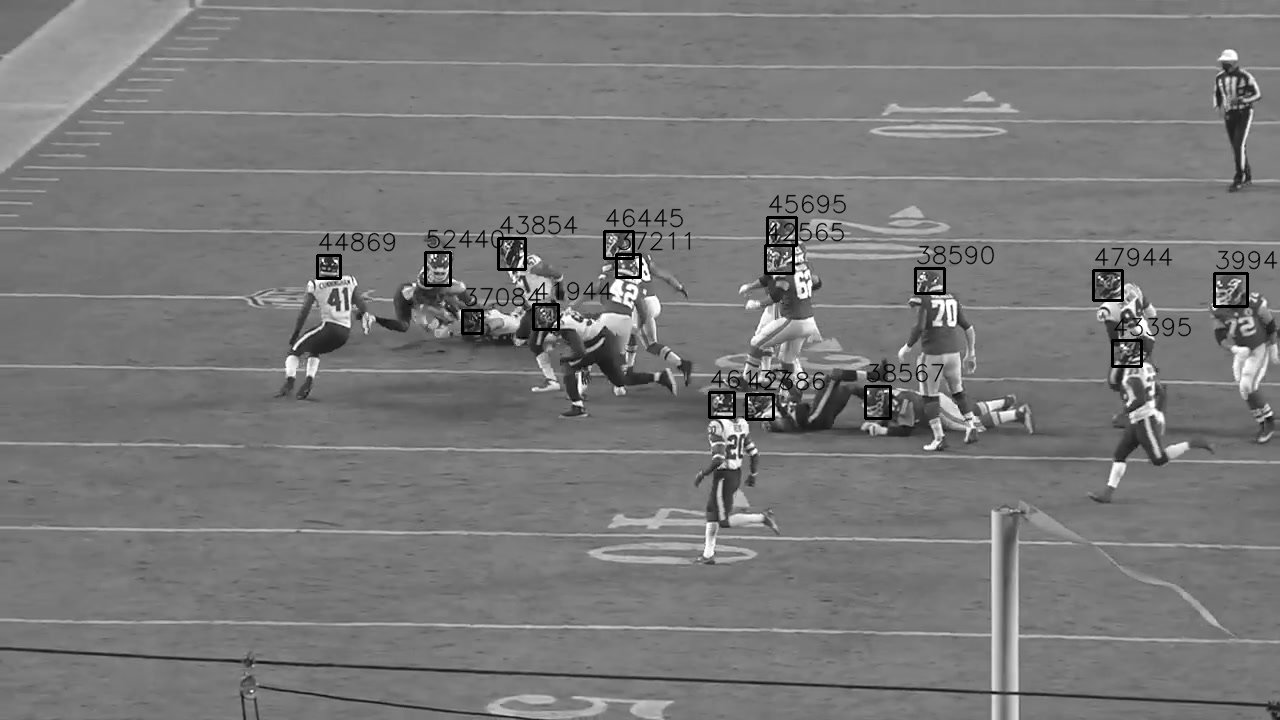

In [50]:
helmets_dets_df = video_helmets_dict['58168_003392_Endzone.mp4']
boxes, labels = get_helmet_detections(helmets_dets_df, 500, 'Endzone')
img_array = cv2.imread(os.path.join(FRAMES_DIR, '58168_003392_Endzone.mp4_0500.jpg'), 0)
img_array = draw_boxes(boxes, labels, img_array)
array_to_image(img_array)

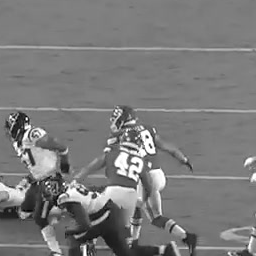

In [51]:
### show the fixed crop from 2 players, centered in the center point between them
crops = get_contact_image('58168_003392', 500, 46445, 37211)
# the 6th image is the selected frame (500) with the enzdone view
array_to_image(crops[6])

## The PlayerContactDataset

In [260]:
# data augmentation for train set
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])
# simple tensor transformation and normalization for test set
valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [348]:
p2p_contact_df[['game_play', 'frame', 
                              'nfl_player_id_1', 'nfl_player_id_2']]

,game_play,frame,nfl_player_id_1,nfl_player_id_2
10,58168_003392,300,38590,44822
11,58168_003392,300,38590,39947
13,58168_003392,300,38590,42565
50,58168_003392,300,41944,42565
119,58168_003392,300,37211,46445
...,...,...,...,...
4721272,58582_003121,840,45287,47872
4721375,58582_003121,846,36712,52493
4721441,58582_003121,846,39971,47872
4721502,58582_003121,846,45009,46133


In [353]:
class PlayerContactDataset(Dataset):
    """
    PlayerContact dataset that returns an image and feature vector
    """
    def __init__(self, data_dir, contact_df, split='train', transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.split = split
        self.contact_df = contact_df.fillna(-1) # fill nan with -1 for feature vector
        
    def __getitem__(self, idx):
        # get the row
        row = self.contact_df.iloc[idx] 
        contact_image_cols = ['game_play', 'frame', 
                              'nfl_player_id_1', 'nfl_player_id_2']
        game_play, frame, player_1, player_2 = row[contact_image_cols]
        # change the frame randomly if training set
        if self.split == 'train':
            frame = frame + random.randint(-6, 6)
        # get the image crop
        image = get_contact_image(game_play, frame, player_1, player_2, FRAMES_DIR)
        # transform image
        if (self.transform):
            image = np.array(image).transpose(1, 2, 0)  
            image = self.transform(image=image)["image"]
        
        # get feature vector
        if row['nfl_player_id_2'] == -1:
            # if ground contact, retrieve only player 1 data and no p2p distance
            feature_cols = ['x_position_1', 'y_position_1', 'speed_1', 'distance_1', 
                            'direction_1', 'orientation_1', 'acceleration_1', 'sa_1']
        else:
            feature_cols = ['x_position_1', 'y_position_1', 'speed_1', 'distance_1', 
                            'direction_1', 'orientation_1', 'acceleration_1', 'sa_1',
                            'x_position_2', 'y_position_2', 'speed_2', 'distance_2', 
                            'direction_2', 'orientation_2', 'acceleration_2', 'sa_2',
                            'p2p_distance']
            
        feature = torch.tensor(row[feature_cols]).float()
        
        # get the class label
        label = torch.tensor(row['contact_true'])
        
        return image, feature, label
    
    def __len__(self):
        return len(self.contact_df)

### Create the dataset instances and train test split

In [363]:
p2p_contact_df = train_contact_df[train_contact_df['nfl_player_id_2'] != -1]
p2p_train_df, p2p_test_df = train_test_split(p2p_contact_df, test_size=0.2, random_state=42)
p2p_dataset_train = PlayerContactDataset(FRAMES_DIR, p2p_train_df, split='train', transform=train_aug)
p2p_dataset_test = PlayerContactDataset(FRAMES_DIR, p2p_test_df, split='test', transform=valid_aug)
print(f"Train size: {len(p2p_dataset_train)}")
print(f"Test size: {len(p2p_dataset_test)}")

Train size: 199926
Test size: 49982


In [364]:
crops, feature, label = p2p_dataset_train[0]
print(label)
print(crops.shape)
print(feature.size())

tensor(0)
torch.Size([26, 256, 256])
torch.Size([17])


###  Utils to show images from dataset

In [365]:
def inverse_normalize(tensor, mean, std):
    inv_norm_tensor = tensor.detach().clone()
    inv_norm_tensor.mul_(std).add_(mean)
    # The normalize code -> channel_tensor.sub_(c_mean).div_(c_std)
        
    return inv_norm_tensor

def tensor_to_image(tensor, is_normalized=True):
    img = tensor.detach().clone()
    if is_normalized:
        img = inverse_normalize(img, mean=(0), std=(1.))
    img = (img.numpy()*255).astype(np.uint8)
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    return img

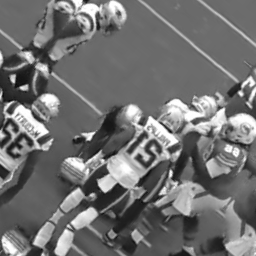

In [366]:
tensor_to_image(crops[6])

## Data Loaders

In [367]:
BATCH_SIZE = 32

loader_p2p_train = DataLoader(p2p_dataset_train,
                         batch_size=BATCH_SIZE,
                         shuffle=True, 
                         num_workers=0,
                         drop_last=True) # drop last batch with size < 8 so that the batchnorm layers dont fail

loader_p2p_test = DataLoader(p2p_dataset_test,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0,
                         drop_last=False)

In [368]:
# get one batch
images, feature, labels = next(iter(loader_p2p_train))
# check the batch size
print(f'Batch size: {len(images)}')
print(f'IMG Data shape: {images.shape}')
print(f'feature Data shape: {feature.shape}')
print(f'Label Data shape: {labels.shape}')

Batch size: 32
IMG Data shape: torch.Size([32, 26, 256, 256])
feature Data shape: torch.Size([32, 17])
Label Data shape: torch.Size([32])


## Load a pretrained efficientnet model with no classification head

In [369]:
def get_efficientnet_model(pretrained=True, fine_tune=True, num_channels=26):
    """
    Returns en efficientnetB0 model that retturns the flattenned feature
    """
    model = models.efficientnet_b0(pretrained=pretrained)
    if fine_tune:
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        for params in model.parameters():
            params.requires_grad = False
            
    # Replace the final classification head with a flatten layer
    model.classifier = nn.Flatten()
    # Replace first layer to be able to use images of more than 3 channels as input
    model.features[0][0] = nn.Conv2d(num_channels, 32, kernel_size=(3, 3), 
                                        stride=(2, 2), padding=(1, 1), 
                                        bias=False)
            
    return model

## The Multi Input model

In [370]:
class ContactMultiInputNetwork(nn.Module):
    def __init__(self, num_classes=1, num_features=8):
        super(ContactMultiInputNetwork, self).__init__()
        self.efficientnet = get_efficientnet_model()
        
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(1536, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        # x[0] contains the image tensor and x[1] the feature vector tensor
        img_feature = self.efficientnet(x[0])
        # shape = (batch_size, 1280)
        x = F.relu(self.bn1(self.fc1(x[1])))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        # shape = (batch_size, 256)
        # concatenate image and vector features
        x = torch.cat([img_feature, x], dim=1)
        # shape = (batch_size, 1536)
        # final classification
        x = self.fc3(x)
        # shape = (batch_size, 1)
        
        return x

In [371]:
# 1 class for binary output
# feature vector has size 17 for p2p and 8 for ground
model = ContactMultiInputNetwork(num_classes=1, num_features=17) 
model([images, feature]).size()

C:\Users\AT016638\.conda\envs\contact\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\AT016638\.conda\envs\contact\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([32, 1])

## Model Training

### Training utils

In [372]:
class Averager():
    """
    An Averager keeps track of the training and validation loss values
    and helps to get the average for each epoch as well
    """
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0



def save_model(epoch, model, optimizer, model_name='model', out_dir='.'):
    """
    Function to save the trained model
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f'{out_dir}/{model_name}.pth')




class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf'), model_name='model'
    ):
        self.best_valid_loss = best_valid_loss
        self.model_name = model_name
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, out_dir='.'
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            model_name = f'b_m_{self.model_name}_epoch_{epoch+1}'
            save_model(epoch, model, optimizer, model_name, out_dir)




def save_loss_plot(output_dir, mean_train_loss, mean_valid_loss, epoch_num, model_name):
    """
    Save plots with the loss curves of the model training
    """
    fig, ax = plt.subplots(figsize=(15,10))

    ax.plot(np.arange(epoch_num)+1, mean_train_loss, label='Training loss')
    ax.plot(np.arange(epoch_num)+1, mean_valid_loss, label='Validation Loss')
        
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    ax.set_title('Loss Curves')
    ax.legend()
    fig.savefig(f"{output_dir}/{model_name}_epoch_loss.png")

    print('SAVING PLOTS COMPLETE...')

    plt.close('all')

In [ ]:
def get_pos_weight(train_df):
    """
    Returns a positive class weight equal to n_negative_contact / n_positive contact
    this way, the positive contacts will have more weight in the loss function
    """
    num_pos_contacts = train_df['contact_true'].sum()
    num_neg_contacts = len(train_df) - num_pos_contacts
    pos_weight = torch.tensor([num_neg_contacts / num_pos_contacts])
    
    return pos_weight

### Training 1 epoch

In [373]:
def train_one_epoch(model, data_loader, criterion, optimizer, device, train_loss_averager):
    """
    Function that trains the given model for one epoch 
    with the given data loader
    """
    # activate model training mode in case its in evaluation mode
    model.train()
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    for i, (img_data, feature_data, labels) in enumerate(prog_bar):
        # send data to device
        img_data = img_data.to(device)
        feature_data = feature_data.to(device)
        labels = labels.to(device).to(torch.float32)
        # reset the gradient accummulation from the previous batch
        optimizer.zero_grad()
        # make a prediction with the model
        prediction = model([img_data, feature_data]).to(torch.float32).squeeze(dim=1)
        # compute the loss 
        loss = criterion(prediction, labels)
        # save loss values to the averaher
        train_loss_averager.send(loss.item())
        # backpropagate the loss gradient
        loss.backward()
        # uptade parameters
        optimizer.step()

        # print the mean batch loss at each iteration
        prog_bar.set_description(desc=f"Training Loss: {train_loss_averager.value:.4f}")

### Validate Function

In [374]:
def validate_model(model, data_loader, criterion, device, val_loss_averager):
    """
    Uses the model on all the data from the data loader and 
    returns the predictions and the true targets. It also updates
    the loss averager
    """
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    loss_list = np.array([])
    total_predictions = torch.tensor([]).to(device)
    total_target_labels = torch.tensor([]).to(device)
    
    for i, (img_data, feature_data, labels) in enumerate(prog_bar):
        # send data to device
        img_data = img_data.to(device)
        feature_data = feature_data.to(device)
        labels = labels.to(device).to(torch.float32)
        # make a prediction with the model in evaluation mode
        with torch.no_grad():
            # activate evaluation mode for batchnorm layers
            model.eval()
            prediction = model([img_data, feature_data]).to(torch.float32).squeeze(dim=1)

        # add batch predictions and true labels to total lists
        total_predictions = torch.cat((total_predictions, prediction), dim=0)    
        total_target_labels = torch.cat((total_target_labels, labels), dim=0)    
        # compute the loss 
        loss = criterion(prediction, labels)
        # update loss averager
        val_loss_averager.send(loss.item())
        
        # print the mean batch loss at each iteration
        prog_bar.set_description(desc=f"Validation Loss: {val_loss_averager.value:.4f}")

    # return total predictions and total true_labels
    return total_predictions, total_target_labels

### The Fit Function

In [ ]:
def fit_model(model, loader_train, loader_test, criterion, scheduler, optimizer, epochs):
    """
    Trains the model for the given number of epochs on the given data loaders
    """
    # initialize the loss Averager class
    train_loss_hist = Averager()
    val_loss_hist = Averager()
    # initialize SaveBestModel class
    save_best_model = SaveBestModel(model_name=MODEL_NAME)
    # mean losses for train and validation at every epoch
    mean_train_losses = []
    mean_validation_losses = []

    # epoch loop
    for epoch in range(epochs):
        print(f"Starting epoch {epoch+1}")
        # reset the training and valitation loss histories for the current epoch
        train_loss_hist.reset()
        val_loss_hist.reset()

        # start timer and carry out training and evaluation
        start = time.time()
        # train one epoch
        train_one_epoch(model, loader_train, criterion, optimizer, 
                        DEVICE, train_loss_hist)
        # update the lr scheduler
        scheduler.step()
        #evaluate the model
        y_pred, y_true = validate_model(model, loader_test, criterion,
                                        DEVICE, val_loss_hist)

        print(f"Epoch #{epoch+1} train_loss: {train_loss_hist.value:.3f}")
        print(f"Epoch #{epoch+1} validation_loss: {val_loss_hist.value:.3f}")
        end = time.time()
        print(f"Took {(end - start):.3f} seconds for epoch {epoch+1}")

        # save the mean train and validation losses of this epoch
        mean_train_losses.append(train_loss_hist.value)
        mean_validation_losses.append(val_loss_hist.value)

        # save the best model until now if we have the minimum val loss this epoch
        save_best_model(val_loss_hist.value, epoch, model, optimizer, 
                        out_dir=MODEL_DIR)

        #save the current epoch model
        save_model(epoch, model, optimizer, model_name=MODEL_NAME,
                   out_dir=MODEL_DIR)

        #save the loss plot
        save_loss_plot('training_plots', mean_train_losses, mean_validation_losses, 
                       epoch+1, MODEL_NAME)
        print('\n')

    print('Training done')

### Constants

In [376]:
CLASSES = ['0', '1']
# detect the device (GPU or CPU)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

MODEL_NAME = 'multi_frame_p2p_v1'
MODEL_DIR = 'trained_models'
PLOT_DIR = 'training_plots'

!mkdir {MODEL_DIR}
!mkdir {PLOT_DIR}

A subdirectory or file trained_models already exists.
A subdirectory or file training_plots already exists.


### Training parameters

In [380]:
# set the number of epochs
EPOCHS = 20
# set the learning rate
LR = 0.001

# initialize model and send to device
model = ContactMultiInputNetwork(num_classes=1, num_features=17)  # 1 output for binary prediction
model = model.to(DEVICE)

# initialize Adam optimizer with default parameters (like the paper)
optimizer = Adam(model.parameters(), lr=LR)
# so it halves the learning rate every 5 epochs
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0, total_iters=EPOCHS)
# initialize loss function (sigmoid + binary cross entropy)
# set a positive class weight equal to n_negative_contact / n_positive contact
# this way, the positive contacts will have more weight in the loss function
pos_weight = get_pos_weight(p2p_train_df).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

### Start the training

In [ ]:
fit_model(model, loader_p2p_train, loader_p2p_test, criterion, scheduler, optimizer, EPOCHS)

Starting epoch 1


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #1 train_loss: 0.669
Epoch #1 validation_loss: 0.540
Took 34381.814 seconds for epoch 1

Best validation loss: 0.5399904603069402

Saving best model for epoch: 1

SAVING PLOTS COMPLETE...


Starting epoch 2


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #2 train_loss: 0.569
Epoch #2 validation_loss: 0.521
Took 34034.017 seconds for epoch 2

Best validation loss: 0.5211053952937242

Saving best model for epoch: 2

SAVING PLOTS COMPLETE...


Starting epoch 3


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #3 train_loss: 0.542
Epoch #3 validation_loss: 0.496
Took 34144.658 seconds for epoch 3

Best validation loss: 0.4959589011165839

Saving best model for epoch: 3

SAVING PLOTS COMPLETE...


Starting epoch 4


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #4 train_loss: 0.524
Epoch #4 validation_loss: 0.490
Took 33929.039 seconds for epoch 4

Best validation loss: 0.4901856338550431

Saving best model for epoch: 4

SAVING PLOTS COMPLETE...


Starting epoch 5


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #5 train_loss: 0.506
Epoch #5 validation_loss: 0.454
Took 34160.044 seconds for epoch 5

Best validation loss: 0.45416077712929964

Saving best model for epoch: 5

SAVING PLOTS COMPLETE...


Starting epoch 6


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #6 train_loss: 0.490
Epoch #6 validation_loss: 0.451
Took 34187.555 seconds for epoch 6

Best validation loss: 0.45053525061540967

Saving best model for epoch: 6

SAVING PLOTS COMPLETE...


Starting epoch 7


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #7 train_loss: 0.474
Epoch #7 validation_loss: 0.446
Took 33954.395 seconds for epoch 7

Best validation loss: 0.44615578112429755

Saving best model for epoch: 7

SAVING PLOTS COMPLETE...


Starting epoch 8


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #8 train_loss: 0.460
Epoch #8 validation_loss: 0.431
Took 34183.249 seconds for epoch 8

Best validation loss: 0.4305119070244736

Saving best model for epoch: 8

SAVING PLOTS COMPLETE...


Starting epoch 9


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #9 train_loss: 0.441
Epoch #9 validation_loss: 0.416
Took 34087.875 seconds for epoch 9

Best validation loss: 0.41617550055535746

Saving best model for epoch: 9

SAVING PLOTS COMPLETE...


Starting epoch 10


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #10 train_loss: 0.429
Epoch #10 validation_loss: 0.386
Took 34268.571 seconds for epoch 10

Best validation loss: 0.3856844999821482

Saving best model for epoch: 10

SAVING PLOTS COMPLETE...


Starting epoch 11


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch #11 train_loss: 0.413
Epoch #11 validation_loss: 0.367
Took 34190.092 seconds for epoch 11

Best validation loss: 0.3669256603061466

Saving best model for epoch: 11

SAVING PLOTS COMPLETE...


Starting epoch 12


  0%|          | 0/6247 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]